In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Output')
cur_date = "011921"

library(readxl)
library(data.table)
library(ggplot2)
library(factoextra)
library(dplyr)
library(tidyverse)
library(gridExtra)
#library(rgl) # for 3d plots 
library(cluster)
library(vegan)
library(fpc)
library(ggdendro)
library(NbClust)
library(ggrepel)

#reading in file
cytokines <- data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))

#reading in demographics file
subjects = data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ purrr   0.3.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘gridExtra’


The following object is masked from ‘pac

This is an analysis to determine how baseline cytokines cluster (using k means) and to get their corresponding eigencytokines by compartment.

In [2]:
# Separating the cytokine data into compartment dfs
cytokines <- cytokines %>% 
    filter(Group == 'NS') %>% #only want non-smokers for baseline analysis
    group_by(Compartment) %>% 
    group_split
ELF <- cytokines[[1]]
NLF <- cytokines[[2]]
Serum <- cytokines[[3]]
Sputum <- cytokines[[4]]

# reshaping data 
ELF <- reshape2::dcast(ELF, SubjectID ~ Protein, value.var="Conc_pslog2") %>% 
  column_to_rownames("SubjectID") 
NLF <- reshape2::dcast(NLF, SubjectID ~ Protein, value.var="Conc_pslog2") %>% 
  column_to_rownames("SubjectID") 
Serum <- reshape2::dcast(Serum, SubjectID ~ Protein, value.var="Conc_pslog2") %>% 
  column_to_rownames("SubjectID") 
Sputum <- reshape2::dcast(Sputum, SubjectID ~ Protein, value.var="Conc_pslog2") %>% 
  column_to_rownames("SubjectID") 
  
#background filter eliminating any cytokines that are not expressed in a compartment  
NLF$I309 <- NULL
Sputum$I309 <- NULL 

In [3]:
#Z-score normalizing across cytokines within each compartment (using pseudolog2 of concentrations)
# the scale function operates across columns 
ELF_scaled <- ELF %>% 
  scale() %>% 
  as.data.frame()
NLF_scaled <- NLF %>% 
  scale() %>% 
  as.data.frame()
Serum_scaled <- Serum %>% 
  scale() %>% 
  as.data.frame()
Sputum_scaled <- Sputum %>% 
  scale() %>% 
  as.data.frame()
#Check that we now have a mean of ~0 and SD of 1 for each cytokine
# colMeans(ELF_scaled)
# apply(ELF_scaled, 2, sd)
# colMeans(NLF_scaled)
# apply(NLF_scaled, 2, sd)
# colMeans(Serum_scaled)
# apply(Serum_scaled, 2, sd)
# colMeans(Sputum_scaled)
# apply(Sputum_scaled, 2, sd)

In [15]:
# Export non-normalized data for each compartment 
write.csv(ELF, paste0(Output,"/", cur_date, "ELF_NonNorm.csv"), row.names=TRUE)
write.csv(NLF, paste0(Output,"/", cur_date, "NLF_NonNorm.csv"), row.names=TRUE)
write.csv(Serum, paste0(Output,"/", cur_date, "Serum_NonNorm.csv"), row.names=TRUE)
write.csv(Sputum, paste0(Output,"/", cur_date, "Sputum_NonNorm.csv"), row.names=TRUE)

#Export scaled data for each compartment
write.csv(ELF_scaled, paste0(Output,"/", cur_date, "ELF_Scaled.csv"), row.names=TRUE)
write.csv(NLF_scaled, paste0(Output,"/", cur_date, "NLF_Scaled.csv"), row.names=TRUE)
write.csv(Serum_scaled, paste0(Output,"/", cur_date, "Serum_Scaled.csv"), row.names=TRUE)
write.csv(Sputum_scaled, paste0(Output,"/", cur_date, "Sputum_Scaled.csv"), row.names=TRUE)

# Baseline Clusters

First, we can estimate the optimal number of clusters, as described in:
- https://afit-r.github.io/kmeans_clustering
- https://www.datanovia.com/en/lessons/k-means-clustering-in-r-algorith-and-practical-examples/
- https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

> - Compute k-means clustering using different values of clusters k
> - Next, the wss (within sum of square) is drawn according to the number of clusters
> - The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.
> - The R function fviz_nbclust() [in factoextra package] provides a convenient solution to estimate the optimal number of clusters.

In [ ]:
# ELF
fviz_nbclust(ELF, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # The generated plot represents the variance within the clusters. It decreases as k increases, but it can be seen a bend (or “elbow”) at k = 4
fviz_nbclust(ELF, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2 

In [ ]:
# NLF
fviz_nbclust(NLF, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 4
fviz_nbclust(NLF, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 4 

In [ ]:
# Serum
fviz_nbclust(Serum, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 2
fviz_nbclust(Serum, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2 

In [ ]:
# Sputum
fviz_nbclust(Sputum, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 2
fviz_nbclust(Sputum, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2

Run the cluster code using the identified number of clusters for subjects first.

In [4]:
# Since the initial cluster assignments are random, we need to set the seed to ensure reproducibility
set.seed(151)

# Running the basic cluster analysis code
# kmeans(x, centers, iter.max = 10, nstart = 1)
# where:
#   x: numeric matrix, numeric data frame or a numeric vector
#   centers: Possible values are the number of clusters (k) or a set of initial (distinct) cluster centers. If a number, a random set of (distinct) rows in x is chosen as the initial centers.
#   iter.max: The maximum number of iterations allowed. Default value is 10.
#   nstart: The number of random starting partitions when centers is a number.
#   This means that R will try nstart different random starting assignments and then select the best results corresponding to the one with the lowest within cluster variation. The default value of nstart in R is one. But, it’s strongly recommended to compute k-means clustering with a large value of nstart such as 25 or 50, in order to have a more stable result.

# Testing different numbers of clusters (k)

# ELF
ELF_Cluster_k2 <- kmeans(ELF, centers = 2, nstart=25)
ELF_Cluster_k3 <- kmeans(ELF, centers = 3, nstart=25)
ELF_Cluster_k4 <- kmeans(ELF, centers = 4, nstart=25)
ELF_Cluster_k5 <- kmeans(ELF, centers = 5, nstart=25)
ELF_Cluster_k6 <- kmeans(ELF, centers = 6, nstart=25)
ELF_Cluster_k7 <- kmeans(ELF, centers = 7, nstart=25)
ELF_Cluster_k8 <- kmeans(ELF, centers = 8, nstart=25)
ELF_Cluster_k9 <- kmeans(ELF, centers = 9, nstart=25)
ELF_Cluster_k10 <- kmeans(ELF, centers = 10, nstart=25)

# Plots to compare
e2 <- fviz_cluster(ELF_Cluster_k2, data = ELF) + ggtitle("k = 2")
e3 <- fviz_cluster(ELF_Cluster_k3, data = ELF) + ggtitle("k = 3")
e4 <- fviz_cluster(ELF_Cluster_k4, data = ELF) + ggtitle("k = 4")
e5 <- fviz_cluster(ELF_Cluster_k5, data = ELF) + ggtitle("k = 5")
e6 <- fviz_cluster(ELF_Cluster_k6, data = ELF) + ggtitle("k = 6")
e7 <- fviz_cluster(ELF_Cluster_k7, data = ELF) + ggtitle("k = 7")
e8 <- fviz_cluster(ELF_Cluster_k8, data = ELF) + ggtitle("k = 8")
e9 <- fviz_cluster(ELF_Cluster_k9, data = ELF) + ggtitle("k = 9")
e10 <- fviz_cluster(ELF_Cluster_k10, data = ELF) + ggtitle("k = 10")

#grid.arrange(e2, e3, e4, e5, e6, e7, e8, e9, e10, nrow = 3, top="Subject Clusters - ELF")
ELF_subs_plots <- arrangeGrob(e2, e3, e4, e5, e6, e7, e8, e9, e10, nrow=3, top="Subject Clusters - ELF") 

#NLF
NLF_Cluster_k2 <- kmeans(NLF, centers = 2, nstart=25)
NLF_Cluster_k3 <- kmeans(NLF, centers = 3, nstart=25)
NLF_Cluster_k4 <- kmeans(NLF, centers = 4, nstart=25)
NLF_Cluster_k5 <- kmeans(NLF, centers = 5, nstart=25)
NLF_Cluster_k6 <- kmeans(NLF, centers = 6, nstart=25)
NLF_Cluster_k7 <- kmeans(NLF, centers = 7, nstart=25)
NLF_Cluster_k8 <- kmeans(NLF, centers = 8, nstart=25)
NLF_Cluster_k9 <- kmeans(NLF, centers = 9, nstart=25)
NLF_Cluster_k10 <- kmeans(NLF, centers = 10, nstart=25)

# Plots to compare
n2 <- fviz_cluster(NLF_Cluster_k2, data = NLF) + ggtitle("k = 2")
n3 <- fviz_cluster(NLF_Cluster_k3, data = NLF) + ggtitle("k = 3")
n4 <- fviz_cluster(NLF_Cluster_k4, data = NLF) + ggtitle("k = 4")
n5 <- fviz_cluster(NLF_Cluster_k5, data = NLF) + ggtitle("k = 5")
n6 <- fviz_cluster(NLF_Cluster_k6, data = NLF) + ggtitle("k = 6")
n7 <- fviz_cluster(NLF_Cluster_k7, data = NLF) + ggtitle("k = 7")
n8 <- fviz_cluster(NLF_Cluster_k8, data = NLF) + ggtitle("k = 8")
n9 <- fviz_cluster(NLF_Cluster_k9, data = NLF) + ggtitle("k = 9")
n10 <- fviz_cluster(NLF_Cluster_k10, data = NLF) + ggtitle("k = 10")

#grid.arrange(n2, n3, n4, n5, n6, n7, n8, n9, n10, nrow = 3, top="Subject Clusters - NLF")
NLF_subs_plots <- arrangeGrob(n2, n3, n4, n5, n6, n7, n8, n9, n10, nrow=3, top="Subject Clusters - NLF") 

#Serum
Serum_Cluster_k2 <- kmeans(Serum, centers = 2, nstart=25)
Serum_Cluster_k3 <- kmeans(Serum, centers = 3, nstart=25)
Serum_Cluster_k4 <- kmeans(Serum, centers = 4, nstart=25)
Serum_Cluster_k5 <- kmeans(Serum, centers = 5, nstart=25)
Serum_Cluster_k6 <- kmeans(Serum, centers = 6, nstart=25)
Serum_Cluster_k7 <- kmeans(Serum, centers = 7, nstart=25)
Serum_Cluster_k8 <- kmeans(Serum, centers = 8, nstart=25)
Serum_Cluster_k9 <- kmeans(Serum, centers = 9, nstart=25)
Serum_Cluster_k10 <- kmeans(Serum, centers = 10, nstart=25)

# Plots to compare
se2 <- fviz_cluster(Serum_Cluster_k2, data = Serum) + ggtitle("k = 2")
se3 <- fviz_cluster(Serum_Cluster_k3, data = Serum) + ggtitle("k = 3")
se4 <- fviz_cluster(Serum_Cluster_k4, data = Serum) + ggtitle("k = 4")
se5 <- fviz_cluster(Serum_Cluster_k5, data = Serum) + ggtitle("k = 5")
se6 <- fviz_cluster(Serum_Cluster_k6, data = Serum) + ggtitle("k = 6")
se7 <- fviz_cluster(Serum_Cluster_k7, data = Serum) + ggtitle("k = 7")
se8 <- fviz_cluster(Serum_Cluster_k8, data = Serum) + ggtitle("k = 8")
se9 <- fviz_cluster(Serum_Cluster_k9, data = Serum) + ggtitle("k = 9")
se10 <- fviz_cluster(Serum_Cluster_k10, data = Serum) + ggtitle("k = 10")

#grid.arrange(se2, se3, se4, se5, se6, se7, se8, se9, se10, nrow = 3, top="Subject Clusters - Serum")
Serum_subs_plots <- arrangeGrob(se2, se3, se4, se5, se6, se7, se8, se9, se10, nrow=3, top="Subject Clusters - Serum") 

#sputum
Sputum_Cluster_k2 <- kmeans(Sputum, centers = 2, nstart=25)
Sputum_Cluster_k3 <- kmeans(Sputum, centers = 3, nstart=25)
Sputum_Cluster_k4 <- kmeans(Sputum, centers = 4, nstart=25)
Sputum_Cluster_k5 <- kmeans(Sputum, centers = 5, nstart=25)
Sputum_Cluster_k6 <- kmeans(Sputum, centers = 6, nstart=25)
Sputum_Cluster_k7 <- kmeans(Sputum, centers = 7, nstart=25)
Sputum_Cluster_k8 <- kmeans(Sputum, centers = 8, nstart=25)
Sputum_Cluster_k9 <- kmeans(Sputum, centers = 9, nstart=25)
Sputum_Cluster_k10 <- kmeans(Sputum, centers = 10, nstart=25)

# Plots to compare
sp2 <- fviz_cluster(Sputum_Cluster_k2, data = Sputum) + ggtitle("k = 2")
sp3 <- fviz_cluster(Sputum_Cluster_k3, data = Sputum) + ggtitle("k = 3")
sp4 <- fviz_cluster(Sputum_Cluster_k4, data = Sputum) + ggtitle("k = 4")
sp5 <- fviz_cluster(Sputum_Cluster_k5, data = Sputum) + ggtitle("k = 5")
sp6 <- fviz_cluster(Sputum_Cluster_k6, data = Sputum) + ggtitle("k = 6")
sp7 <- fviz_cluster(Sputum_Cluster_k7, data = Sputum) + ggtitle("k = 7")
sp8 <- fviz_cluster(Sputum_Cluster_k8, data = Sputum) + ggtitle("k = 8")
sp9 <- fviz_cluster(Sputum_Cluster_k9, data = Sputum) + ggtitle("k = 9")
sp10 <- fviz_cluster(Sputum_Cluster_k10, data = Sputum) + ggtitle("k = 10")

#grid.arrange(sp2, sp3, sp4, sp5, sp6, sp7, sp8, sp9, sp10, nrow = 3, top="Subject Clusters - Sputum")
Sputum_subs_plots <- arrangeGrob(sp2, sp3, sp4, sp5, sp6, sp7, sp8, sp9, sp10, nrow=3, top="Subject Clusters - Sputum") 

In [ ]:
#exporitng all figures
ggsave(paste0(Output,"/", cur_date, "ELF_subjects.png"), ELF_subs_plots, width=30, height=24.47)
ggsave(paste0(Output,"/", cur_date, "NLF_subjects.png"), NLF_subs_plots, width=30, height=24.47)
ggsave(paste0(Output,"/", cur_date, "Serum_subjects.png"), Serum_subs_plots, width=30, height=24.7)
ggsave(paste0(Output,"/", cur_date, "Sputum_subjects.png"), Sputum_subs_plots, width=30, height=24.47)

Principal Component Analysis (PCA) for 3D plots

In [5]:
# transforming the data
tELF <- as.data.frame(t(ELF))
tNLF <- as.data.frame(t(NLF))
tSerum <- as.data.frame(t(Serum))
tSputum <- as.data.frame(t(Sputum))

#pca
pca_ELF <- prcomp(tELF)
pca_NLF <- prcomp(tNLF)
pca_Serum <- prcomp(tSerum)
pca_Sputum <- prcomp(tSputum)

In [ ]:
############################################
# 3d plots 
############################################

#ELF
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k2$cluster)
# rgl.postscript("plot.pdf",fmt="pdf") # code to export a screenshot of the current plot 
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k3$cluster)
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k4$cluster)
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k5$cluster)
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k6$cluster)
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k7$cluster)
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k8$cluster)
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k9$cluster)
plot3d(pca_ELF$rotation[,1:3], col=ELF_Cluster_k10$cluster)

#NLF
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k2$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k3$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k4$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k5$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k6$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k7$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k8$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k9$cluster)
plot3d(pca_NLF$rotation[,1:3], col=NLF_Cluster_k10$cluster)

#Serum
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k2$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k3$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k4$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k5$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k6$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k7$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k8$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k9$cluster)
plot3d(pca_Serum$rotation[,1:3], col=Serum_Cluster_k10$cluster)

#Sputum
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k2$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k3$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k4$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k5$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k6$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k7$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k8$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k9$cluster)
plot3d(pca_Sputum$rotation[,1:3], col=Sputum_Cluster_k10$cluster)

Estimating optimal number of clusters for cytokines. 

In [ ]:
# ELF
fviz_nbclust(tELF, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 3
fviz_nbclust(tELF, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2 

In [ ]:
# NLF
fviz_nbclust(tNLF, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 3
fviz_nbclust(tNLF, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2

In [ ]:
# Serum
fviz_nbclust(tSerum, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 2
fviz_nbclust(tSerum, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2

In [ ]:
# Sputum
fviz_nbclust(tSputum, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 2
fviz_nbclust(tSputum, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 2

In [6]:
# Testing different numbers of clusters (k)

#ELF
tELF_Cluster_k2 <- kmeans(tELF, centers = 2, nstart=25)
tELF_Cluster_k3 <- kmeans(tELF, centers = 3, nstart=25)
tELF_Cluster_k4 <- kmeans(tELF, centers = 4, nstart=25)
tELF_Cluster_k5 <- kmeans(tELF, centers = 5, nstart=25)
tELF_Cluster_k6 <- kmeans(tELF, centers = 6, nstart=25)
tELF_Cluster_k7 <- kmeans(tELF, centers = 7, nstart=25)
tELF_Cluster_k8 <- kmeans(tELF, centers = 8, nstart=25)
tELF_Cluster_k9 <- kmeans(tELF, centers = 9, nstart=25)
tELF_Cluster_k10 <- kmeans(tELF, centers = 10, nstart=25)

# Plots to compare
te2 <- fviz_cluster(tELF_Cluster_k2, data = tELF) + ggtitle("k = 2")
te3 <- fviz_cluster(tELF_Cluster_k3, data = tELF) + ggtitle("ELF, k = 3")
te4 <- fviz_cluster(tELF_Cluster_k4, data = tELF) + ggtitle("ELF, k = 4")
te5 <- fviz_cluster(tELF_Cluster_k5, data = tELF) + ggtitle("ELF, k = 5")
te6 <- fviz_cluster(tELF_Cluster_k6, data = tELF) + ggtitle("ELF, k = 6")
te7 <- fviz_cluster(tELF_Cluster_k7, data = tELF) + ggtitle("k = 7")
te8 <- fviz_cluster(tELF_Cluster_k8, data = tELF) + ggtitle("k = 8")
te9 <- fviz_cluster(tELF_Cluster_k9, data = tELF) + ggtitle("k = 9")
te10 <- fviz_cluster(tELF_Cluster_k10, data = tELF) + ggtitle("k = 10")

#grid.arrange(te2, te3, te4, te5, te6, te7, te8, te9, te10, nrow = 3, top="Cytokine Clusters - ELF")
tELF_subs_plots <- arrangeGrob(te2, te3, te4, te5, te6, te7, te8, te9, te10, nrow=3, top="Cytokine Clusters - ELF") 

#NLF
tNLF_Cluster_k2 <- kmeans(tNLF, centers = 2, nstart=25)
tNLF_Cluster_k3 <- kmeans(tNLF, centers = 3, nstart=25)
tNLF_Cluster_k4 <- kmeans(tNLF, centers = 4, nstart=25)
tNLF_Cluster_k5 <- kmeans(tNLF, centers = 5, nstart=25)
tNLF_Cluster_k6 <- kmeans(tNLF, centers = 6, nstart=25)
tNLF_Cluster_k7 <- kmeans(tNLF, centers = 7, nstart=25)
tNLF_Cluster_k8 <- kmeans(tNLF, centers = 8, nstart=25)
tNLF_Cluster_k9 <- kmeans(tNLF, centers = 9, nstart=25)
tNLF_Cluster_k10 <- kmeans(tNLF, centers = 10, nstart=25)

# Plots to compare
tn2 <- fviz_cluster(tNLF_Cluster_k2, data = tNLF) + ggtitle("k = 2")
tn3 <- fviz_cluster(tNLF_Cluster_k3, data = tNLF) + ggtitle("NLF, k = 3")
tn4 <- fviz_cluster(tNLF_Cluster_k4, data = tNLF) + ggtitle("NLF, k = 4")
tn5 <- fviz_cluster(tNLF_Cluster_k5, data = tNLF) + ggtitle("NLF, k = 5")
tn6 <- fviz_cluster(tNLF_Cluster_k6, data = tNLF) + ggtitle("NLF, k = 6")
tn7 <- fviz_cluster(tNLF_Cluster_k7, data = tNLF) + ggtitle("k = 7")
tn8 <- fviz_cluster(tNLF_Cluster_k8, data = tNLF) + ggtitle("k = 8")
tn9 <- fviz_cluster(tNLF_Cluster_k9, data = tNLF) + ggtitle("k = 9")
tn10 <- fviz_cluster(tNLF_Cluster_k10, data = tNLF) + ggtitle("k = 10")

#grid.arrange(tn2, tn3, tn4, tn5, tn6, tn7, tn8, tn9, tn10, nrow = 3, top="Cytokine Clusters - NLF")
tNLF_subs_plots <- arrangeGrob(tn2, tn3, tn4, tn5, tn6, tn7, tn8, tn9, tn10, nrow=3, top="Cytokine Clusters - NLF") 

#serum
tSerum_Cluster_k2 <- kmeans(tSerum, centers = 2, nstart=25)
tSerum_Cluster_k3 <- kmeans(tSerum, centers = 3, nstart=25)
tSerum_Cluster_k4 <- kmeans(tSerum, centers = 4, nstart=25)
tSerum_Cluster_k5 <- kmeans(tSerum, centers = 5, nstart=25)
tSerum_Cluster_k6 <- kmeans(tSerum, centers = 6, nstart=25)
tSerum_Cluster_k7 <- kmeans(tSerum, centers = 7, nstart=25)
tSerum_Cluster_k8 <- kmeans(tSerum, centers = 8, nstart=25)
tSerum_Cluster_k9 <- kmeans(tSerum, centers = 9, nstart=25)
tSerum_Cluster_k10 <- kmeans(tSerum, centers = 10, nstart=25)

# Plots to compare
tse2 <- fviz_cluster(tSerum_Cluster_k2, data = tSerum) + ggtitle("k = 2")
tse3 <- fviz_cluster(tSerum_Cluster_k3, data = tSerum) + ggtitle("Serum, k = 3")
tse4 <- fviz_cluster(tSerum_Cluster_k4, data = tSerum) + ggtitle("Serum, k = 4")
tse5 <- fviz_cluster(tSerum_Cluster_k5, data = tSerum) + ggtitle("Serum, k = 5")
tse6 <- fviz_cluster(tSerum_Cluster_k6, data = tSerum) + ggtitle("Serum, k = 6")
tse7 <- fviz_cluster(tSerum_Cluster_k7, data = tSerum) + ggtitle("k = 7")
tse8 <- fviz_cluster(tSerum_Cluster_k8, data = tSerum) + ggtitle("k = 8")
tse9 <- fviz_cluster(tSerum_Cluster_k9, data = tSerum) + ggtitle("k = 9")
tse10 <- fviz_cluster(tSerum_Cluster_k10, data = tSerum) + ggtitle("k = 10")

#grid.arrange(tse2, tse3, tse4, tse5, tse6, tse7, tse8, tse9, tse10, nrow = 3, top="Cytokine Clusters - Serum")
tSerum_subs_plots <- arrangeGrob(tse2, tse3, tse4, tse5, tse6, tse7, tse8, tse9, tse10, nrow=3, top="Cytokine Clusters - Serum") 

#sputum
tSputum_Cluster_k2 <- kmeans(tSputum, centers = 2, nstart=25)
tSputum_Cluster_k3 <- kmeans(tSputum, centers = 3, nstart=25)
tSputum_Cluster_k4 <- kmeans(tSputum, centers = 4, nstart=25)
tSputum_Cluster_k5 <- kmeans(tSputum, centers = 5, nstart=25)
tSputum_Cluster_k6 <- kmeans(tSputum, centers = 6, nstart=25)
tSputum_Cluster_k7 <- kmeans(tSputum, centers = 7, nstart=25)
tSputum_Cluster_k8 <- kmeans(tSputum, centers = 8, nstart=25)
tSputum_Cluster_k9 <- kmeans(tSputum, centers = 9, nstart=25)
tSputum_Cluster_k10 <- kmeans(tSputum, centers = 10, nstart=25)

# Plots to compare
tsp2 <- fviz_cluster(tSputum_Cluster_k2, data = tSputum) + ggtitle("k = 2")
tsp3 <- fviz_cluster(tSputum_Cluster_k3, data = tSputum) + ggtitle("Sputum, k = 3")
tsp4 <- fviz_cluster(tSputum_Cluster_k4, data = tSputum) + ggtitle("Sputum, k = 4")
tsp5 <- fviz_cluster(tSputum_Cluster_k5, data = tSputum) + ggtitle("Sputum, k = 5")
tsp6 <- fviz_cluster(tSputum_Cluster_k6, data = tSputum) + ggtitle("Sputum, k = 6")
tsp7 <- fviz_cluster(tSputum_Cluster_k7, data = tSputum) + ggtitle("k = 7")
tsp8 <- fviz_cluster(tSputum_Cluster_k8, data = tSputum) + ggtitle("k = 8")
tsp9 <- fviz_cluster(tSputum_Cluster_k9, data = tSputum) + ggtitle("k = 9")
tsp10 <- fviz_cluster(tSputum_Cluster_k10, data = tSputum) + ggtitle("k = 10")

#grid.arrange(tsp2, tsp3, tsp4, tsp5, tsp6, tsp7, tsp8, tsp9, tsp10, nrow = 3, top="Cytokine Clusters - Sputum")
tSputum_subs_plots <- arrangeGrob(tsp2, tsp3, tsp4, tsp5, tsp6, tsp7, tsp8, tsp9, tsp10, nrow=3, top="Cytokine Clusters - Sputum") 

In [ ]:
#exporting all figures
ggsave(paste0(Output,"/", cur_date, "ELF_cytokines.png"), tELF_subs_plots, width=30, height=24.47)
ggsave(paste0(Output,"/", cur_date, "NLF_cytokines.png"), tNLF_subs_plots, width=30, height=24.47)
ggsave(paste0(Output,"/", cur_date,"Serum_cytokines.png"), tSerum_subs_plots, width=30, height=24.47)
ggsave(paste0(Output,"/", cur_date, "Sputum_cytokines.png"), tSputum_subs_plots, width=30, height=24.47)

In [ ]:
# Exporting k=3,4,5,6 of all compartments
#grid.arrange(te3, tn3, tse3, tsp3,nrow = 2, top="Cytokines K=3")
k3_cytokines <- arrangeGrob(te3, tn3, tse3, tsp3, nrow=2, top="Cytokines K=3") 
ggsave(paste0(Output,"/", cur_date, "k3_cytokines.png"), k3_cytokines, width=15, height=12.235)

#grid.arrange(te4, tn4, tse4, tsp4,nrow = 2, top="Cytokines K=4")
k4_cytokines <- arrangeGrob(te4, tn4, tse4, tsp4, nrow=2, top="Cytokines K=4") 
ggsave(paste0(Output,"/", cur_date, "k4_cytokines.png"), k4_cytokines, width=15, height=12.235)

#grid.arrange(te5, tn5, tse5, tsp5,nrow = 2, top="Cytokines K=5")
k5_cytokines <- arrangeGrob(te5, tn5, tse5, tsp5, nrow=2, top="Cytokines K=5") 
ggsave(paste0(Output,"/", cur_date, "k5_cytokines.png"), k5_cytokines, width=15, height=12.235)

#grid.arrange(te6, tn6, tse6, tsp6,nrow = 2, top="Cytokines K=6")
k6_cytokines <- arrangeGrob(te6, tn6, tse6, tsp6, nrow=2, top="Cytokines K=6") 
ggsave(paste0(Output,"/", cur_date, "k6_cytokines.png"), k6_cytokines, width=15, height=12.235)

In [ ]:
############################################
# Principal Component Analysis  for 3d plots 
############################################
pca_tELF <- prcomp(ELF)
pca_tNLF <- prcomp(NLF)
pca_tSerum <- prcomp(Serum)
pca_tSputum <- prcomp(Sputum)

############################################
# 3d plots 
############################################

#ELF
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k2$cluster)
# rgl.postscript("plot.pdf",fmt="pdf") # code to export a screenshot of the current plot 
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k3$cluster)
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k4$cluster)
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k5$cluster)
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k6$cluster)
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k7$cluster)
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k8$cluster)
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k9$cluster)
plot3d(pca_tELF$rotation[,1:3], col=tELF_Cluster_k10$cluster)

#NLF
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k2$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k3$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k4$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k5$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k6$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k7$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k8$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k9$cluster)
plot3d(pca_tNLF$rotation[,1:3], col=tNLF_Cluster_k10$cluster)

#Serum
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k2$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k3$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k4$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k5$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k6$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k7$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k8$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k9$cluster)
plot3d(pca_tSerum$rotation[,1:3], col=tSerum_Cluster_k10$cluster)

#Sputum
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k2$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k3$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k4$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k5$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k6$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k7$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k8$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k9$cluster)
plot3d(pca_tSputum$rotation[,1:3], col=tSputum_Cluster_k10$cluster)

In [ ]:
# Exporting final cytokine cluster assignments (k=3)
ELF_k3 <- as.data.frame(tELF_Cluster_k3$cluster) 
colnames(ELF_k3)[1] <- "Cluster"
NLF_k3 <- as.data.frame(tNLF_Cluster_k3$cluster) 
colnames(NLF_k3)[1] <- "Cluster"
Serum_k3 <- as.data.frame(tSerum_Cluster_k3$cluster) 
colnames(Serum_k3)[1] <- "Cluster"
Sputum_k3 <- as.data.frame(tSputum_Cluster_k3$cluster) 
colnames(Sputum_k3)[1] <- "Cluster"

In [ ]:
#Export as csv 
write.csv(ELF_k3, paste0(Output,"/", cur_date, "ELF_cluster_assignments.csv"), row.names=TRUE)
write.csv(NLF_k3, paste0(Output,"/", cur_date, "NLF_cluster_assignments.csv"), row.names=TRUE)
write.csv(Serum_k3, paste0(Output,"/", cur_date, "Serum_cluster_assignments.csv"), row.names=TRUE)
write.csv(Sputum_k3, paste0(Output,"/", cur_date, "Sputum_cluster_assignments.csv"), row.names=TRUE)

# Baseline Cluster Visualization (Figure 3)

Using fviz_cluster is a bit clunky, so the results from kmeans needs to parsed in a way that ggplot will understand.

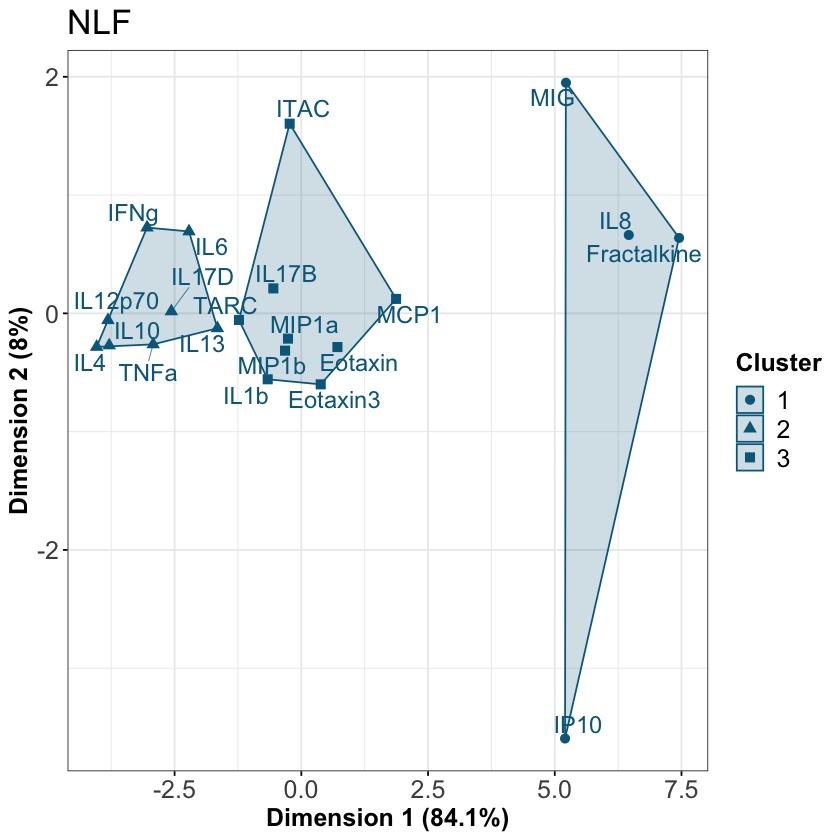

In [7]:
fviz_cluster(tNLF_Cluster_k3, data = tNLF, show.clust.cent = FALSE, labelsize=15, 
                      pointsize=2.5, repel=TRUE, main="NLF", show.legend=F, ggtheme=theme_bw(), 
                      legend.title="Cluster") +

  scale_colour_manual(values = c("deepskyblue4", "deepskyblue4", "deepskyblue4")) +
  scale_fill_manual(values = c("deepskyblue4", "deepskyblue4", "deepskyblue4"))+

  theme(legend.text = element_text(size = 15),axis.text = element_text(size = 15), 
        axis.title.x = element_text(size=15, face="bold"), axis.title.y = element_text(size=15, face="bold"),
        title=element_text(size=17), legend.title = element_text(size=15, face="bold")) + 
        xlab("Dimension 1 (84.1%)") + 
        ylab("Dimension 2 (8%)")

In [8]:
#NLF
trythis<-stats::prcomp(tNLF, scale = TRUE, center = TRUE)
NLF_scores<-as.data.frame(scores(trythis))
NLF_scores$Cluster <- tNLF_Cluster_k3$cluster
NLF_scores$Protein <- rownames(NLF_scores)

#ELF
trythis<-stats::prcomp(tELF, scale = TRUE, center = TRUE)
ELF_scores<-as.data.frame(scores(trythis))
ELF_scores$Cluster <- tELF_Cluster_k3$cluster
ELF_scores$Protein <- rownames(ELF_scores)

#Sputum
trythis<-stats::prcomp(tSputum, scale = TRUE, center = TRUE)
Sputum_scores<-as.data.frame(scores(trythis))
Sputum_scores$Cluster <- tSputum_Cluster_k3$cluster
Sputum_scores$Protein <- rownames(Sputum_scores)

#Serum
trythis<-stats::prcomp(tSerum, scale = TRUE, center = TRUE)
Serum_scores<-as.data.frame(scores(trythis))
Serum_scores$Cluster <- tSerum_Cluster_k3$cluster
Serum_scores$Protein <- rownames(Serum_scores)

In [9]:
#NLF
grp.1.NLF <- NLF_scores[NLF_scores$Cluster == 1, ][chull(NLF_scores %>% filter(Cluster ==1) %>% select(PC1, PC2) ), ]  # hull values for cluster 1
grp.2.NLF <- NLF_scores[NLF_scores$Cluster == 2, ][chull(NLF_scores %>% filter(Cluster ==2) %>% select(PC1, PC2) ), ]  # hull values for cluster 2
grp.3.NLF <- NLF_scores[NLF_scores$Cluster == 3, ][chull(NLF_scores %>% filter(Cluster ==3) %>% select(PC1, PC2) ), ]  # hull values for cluster 3
all_hulls_NLF <- rbind(grp.1.NLF,grp.2.NLF,grp.3.NLF)

#ELF
grp.1.ELF <- ELF_scores[ELF_scores$Cluster == 1, ][chull(ELF_scores %>% filter(Cluster ==1) %>% select(PC1, PC2) ), ]  # hull values for cluster 1
grp.2.ELF <- ELF_scores[ELF_scores$Cluster == 2, ][chull(ELF_scores %>% filter(Cluster ==2) %>% select(PC1, PC2) ), ]  # hull values for cluster 2
grp.3.ELF <- ELF_scores[ELF_scores$Cluster == 3, ][chull(ELF_scores %>% filter(Cluster ==3) %>% select(PC1, PC2) ), ]  # hull values for cluster 3
all_hulls_ELF <- rbind(grp.1.ELF,grp.2.ELF,grp.3.ELF)

#Sputum
grp.1.Sputum <- Sputum_scores[Sputum_scores$Cluster == 1, ][chull(Sputum_scores %>% filter(Cluster ==1) %>% select(PC1, PC2) ), ]  # hull values for cluster 1
grp.2.Sputum <- Sputum_scores[Sputum_scores$Cluster == 2, ][chull(Sputum_scores %>% filter(Cluster ==2) %>% select(PC1, PC2) ), ]  # hull values for cluster 2
grp.3.Sputum <- Sputum_scores[Sputum_scores$Cluster == 3, ][chull(Sputum_scores %>% filter(Cluster ==3) %>% select(PC1, PC2) ), ]  # hull values for cluster 3
all_hulls_Sputum <- rbind(grp.1.Sputum,grp.2.Sputum,grp.3.Sputum)

#Serum
grp.1.Serum <- Serum_scores[Serum_scores$Cluster == 1, ][chull(Serum_scores %>% filter(Cluster ==1) %>% select(PC1, PC2) ), ]  # hull values for cluster 1
grp.2.Serum <- Serum_scores[Serum_scores$Cluster == 2, ][chull(Serum_scores %>% filter(Cluster ==2) %>% select(PC1, PC2) ), ]  # hull values for cluster 2
grp.3.Serum <- Serum_scores[Serum_scores$Cluster == 3, ][chull(Serum_scores %>% filter(Cluster ==3) %>% select(PC1, PC2) ), ]  # hull values for cluster 3
all_hulls_Serum <- rbind(grp.1.Serum,grp.2.Serum,grp.3.Serum)

In [10]:
add_compartment = function(dataframe, compartment_name){
    #"""
    #Takes the dataframes already made from above and adds a column specifying the compartment.

    #:param: compartment dataframe and compartment name
    #:output: a 22x3 matrix containing median, sd, and compartment for each cytokine. 
    #"""
    Compartment = rep(compartment_name, times = length(dataframe$PC1))
    combined_df = data.frame(cbind(dataframe,Compartment))
    combined_df$Compartment = factor(combined_df$Compartment, levels = c('NLF','ELF','Sputum','Serum'))
    return(combined_df)
}

#adding compartment to scores df first
NLF_scores_df = add_compartment(NLF_scores,'NLF')
ELF_scores_df = add_compartment(ELF_scores, 'ELF')
Sputum_scores_df = add_compartment(Sputum_scores, 'Sputum')
Serum_scores_df = add_compartment(Serum_scores, 'Serum')

#adding compartment to all_hulls df
all_hulls_NLF_df = add_compartment(all_hulls_NLF,'NLF')
all_hulls_ELF_df = add_compartment(all_hulls_ELF, 'ELF')
all_hulls_Sputum_df = add_compartment(all_hulls_Sputum, 'Sputum')
all_hulls_Serum_df = add_compartment(all_hulls_Serum, 'Serum')

In [11]:
#creating one df for easier plotting
all_scores_df = data.frame(rbind(NLF_scores_df, ELF_scores_df, Sputum_scores_df, Serum_scores_df))
all_scores_df$Compartment = factor(all_scores_df$Compartment, levels = c('NLF','ELF','Sputum','Serum'))
all_hulls_df = data.frame(rbind(all_hulls_NLF_df, all_hulls_ELF_df, all_hulls_Sputum_df, all_hulls_Serum_df))
all_hulls_df$Compartment = factor(all_hulls_df$Compartment, levels = c('NLF','ELF','Sputum','Serum'))
head(all_scores_df)
head(all_hulls_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Cluster,Protein,Compartment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>
Eotaxin,0.7127336,-0.28474375,-0.570688845,-0.3157711,-0.6961826,-0.56615461,-0.02741451,-0.13437007,-0.03114845,-0.265357960,-0.26734700,0.025141980,0.001471862,0.01950757,3,Eotaxin,NLF
Eotaxin3,0.3826891,-0.60021010,-0.047869268,-1.5458985,0.3563350,0.22051796,-0.24932292,0.04829922,-0.23606837,-0.006315941,0.10627201,-0.022174047,0.014899870,0.03785225,3,Eotaxin3,NLF
Fractalkine,7.4527071,0.63761853,-0.752145171,0.5974622,0.2465759,-0.30090232,-0.29033181,0.12445785,0.00852783,0.072263816,0.11608202,0.066863104,0.078252815,0.05251855,1,Fractalkine,NLF
IFNg,-3.0444072,0.72537725,-0.234201276,0.3696699,-0.4752673,0.51152461,-0.22862573,0.05567241,-0.09099824,-0.101512906,0.06864164,0.004271574,0.084948751,-0.04851898,2,IFNg,NLF
IL10,-3.7904211,-0.27105077,0.004599096,0.1226347,0.4916552,-0.01464086,0.02145299,0.07964596,0.14468572,0.003925357,0.02789657,-0.030201161,0.072841675,0.03098859,2,IL10,NLF
IL12p70,-3.8149332,-0.05750972,-0.036939164,0.1411668,0.3358376,-0.05016687,-0.00736280,0.21300796,0.11717649,-0.086616500,0.06747421,-0.058325133,-0.089181924,0.03024406,2,IL12p70,NLF


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Cluster,Protein,Compartment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<fct>
IP10,5.202835,-3.5942601,0.98539486,0.3571167,-0.4442228,0.1104615,0.023038350,0.09925261,0.03925693,-0.03427295,0.064793481,-0.027366101,-0.00731610,0.0002795017,1,IP10,NLF
MIG,5.220651,1.9498679,1.40805083,-0.3010789,0.3534665,-0.1188223,0.279004434,0.02567575,0.19204128,-0.09776374,-0.111152263,-0.004379876,0.01986237,0.0069588896,1,MIG,NLF
Fractalkine,7.452707,0.6376185,-0.75214517,0.5974622,0.2465759,-0.3009023,-0.290331813,0.12445785,0.00852783,0.07226382,0.116082017,0.066863104,0.07825282,0.0525185545,1,Fractalkine,NLF
IL13,-1.655055,-0.1261421,0.37877275,0.1885381,0.1928502,0.2154420,0.045304300,-0.39889457,0.01879828,-0.12839385,0.075984647,-0.014356542,0.08129437,-0.0100214977,2,IL13,NLF
TNFa,-2.922460,-0.2620804,0.14492210,0.1765332,0.2094573,0.1392350,0.071125366,-0.28683416,-0.01771170,0.11386537,-0.002420488,0.008029352,0.04526922,0.0154455288,2,TNFa,NLF
IL4,-4.037275,-0.2837204,-0.05513009,0.2370201,0.5391394,-0.1052747,-0.002172057,0.16576054,0.12991361,-0.10282848,0.083976062,0.016612431,-0.06269422,-0.0034842385,2,IL4,NLF


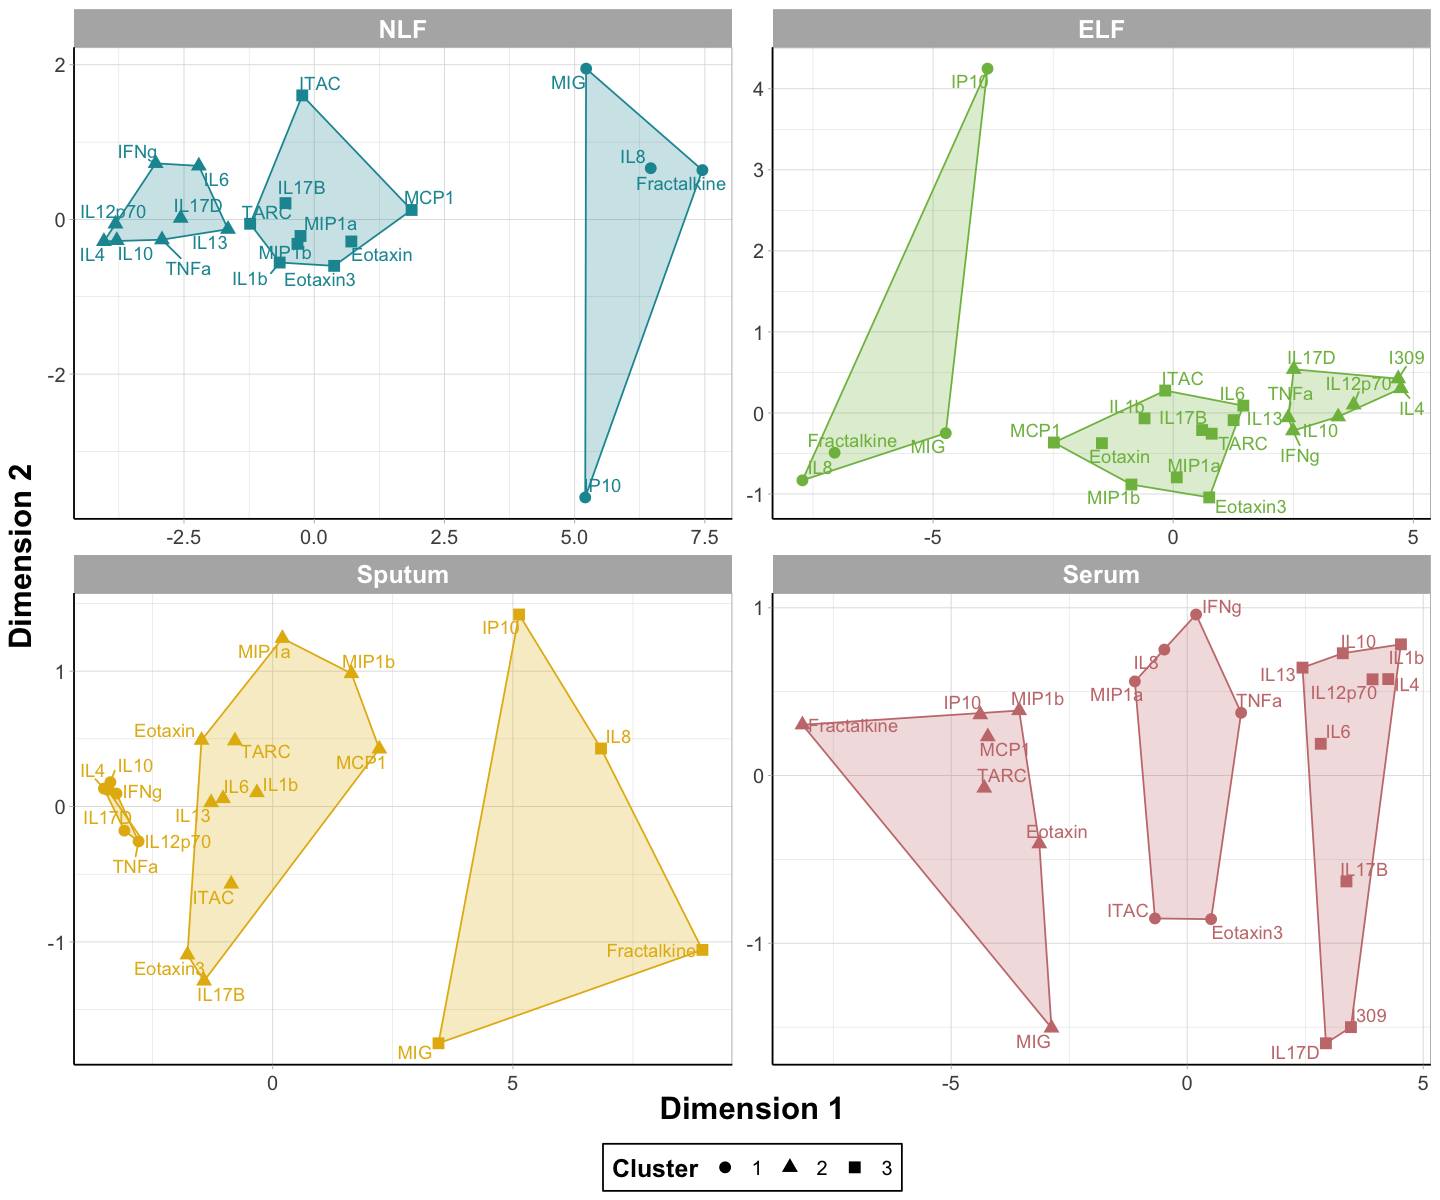

In [13]:
options(repr.plot.width=12, repr.plot.height=10) #changing size
Figure3 = ggplot() + 
  geom_point(data = all_scores_df, aes(x = PC1, y = PC2, color = Compartment, shape = as.factor(Cluster)), size = 3) + 
  geom_text_repel(data = all_scores_df, aes(x = PC1, y = PC2, color = Compartment, label = Protein), 
                  show.legend = FALSE) + 
  geom_polygon(data = all_hulls_df, aes(x = PC1, y = PC2, group = as.factor(Cluster), fill = Compartment, 
                                        color = Compartment), alpha = 0.25, show.legend = FALSE) + 

  facet_wrap(~Compartment, scales = 'free') + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1') + ylab('Dimension 2') + #changing axis labels 
  scale_color_manual(name = 'Cluster',
                      values = c('#1896A1','#7fbb4d','#E4B710','#c87b7c')) +
  scale_fill_manual(name = 'Cluster',
                      values = c('#1896A1','#7fbb4d','#E4B710','#c87b7c')) +

  guides(color = FALSE, shape = guide_legend(title = "Cluster")) #removing legend for color and changing title

Figure3

In [14]:
ggsave(Figure3, 
       filename = 'Figure3.pdf',
       path = Output,
       width = 12, height = 10)